# Projet Web Sémantique - Sujet 1 : Extraction du graphe RDF à partir d'un texte en langage naturel

## 1 - Préparation 

### 1.1 - Librairies nécessaires

In [62]:
import spacy
from spacy import displacy
import re
from rdflib import Graph, URIRef, Literal, Namespace
import networkx as nx
import matplotlib.pyplot as plt
import json
import requests
from typing import List
import unicodedata

### 1.2 - Chargement du modèle NLP de SpaCy

In [63]:
"""
!python3 -m spacy download fr_core_news_sm
"""

'\n!python3 -m spacy download fr_core_news_sm\n'

In [64]:
nlp = spacy.load("fr_core_news_sm")

### 1.3 - Récupération du texte dans le fichier

In [65]:
cheminTexte = "extraitTexte.txt"
with open(cheminTexte, "r", encoding="utf-8") as file:
    texte = file.read()

print(texte)

Alice est née à Paris le 10 mai 1990. Elle a étudié l'Informatique à l'Université de Stanford. Après avoir obtenu son diplôme, elle a travaillé pour une entreprise de technologie à Washington. Actuellement, elle réside à New York. Pendant des années, Alice a acquis une réputation dans le domaine de la technologie et a été reconnue pour son expertise. Cependant, elle a ressenti le besoin de changement et a décidé de déménager sur la côte Est, à New York. Elle consacre son temps à découvrir de nouveaux quartiers, à se immerger dans la diversité culturelle de la ville et à se impliquer dans des projets communautaires. Aujourd'hui, Alice continue de repousser les limites dans le domaine de la technologie, tout en restant attachée sa quête de connaissances. Elle a également commencé à s'impliquer activement dans la communauté technologique locale, participant à des conférences. Sa passion pour le mentorat lui a également conduite à rejoindre des initiatives visant à encourager les jeunes ta

## 2 - Identification des entités

### 2.1 - Librairie SpaCy

In [66]:
i=0
doc=nlp(texte)
entites = []
label = []

for ent in doc.ents:
    entites.append(ent.text)
    label.append(ent.label_)
    #print(ent.text, ent.label_)
    i=i+1
    
print("\n*** Il y a "+str(i)+" entités nommées. ***")
print(entites)
print(label)


*** Il y a 19 entités nommées. ***
['Alice', 'Paris', 'Informatique', 'Université de Stanford', 'Washington', 'New York', 'Alice', 'côte Est', 'New York', 'Alice', 'Technology', 'Engineering', 'Mathematics', 'Jean', 'Paris', 'Alice au fil du temps', 'Alice', 'Jean', 'Lyon']
['PER', 'LOC', 'LOC', 'ORG', 'LOC', 'LOC', 'PER', 'LOC', 'LOC', 'PER', 'MISC', 'MISC', 'PER', 'PER', 'LOC', 'MISC', 'PER', 'PER', 'LOC']


In [68]:
displacy.serve(doc, style="ent", auto_select_port=True)

/usr/local/lib/python3.11/site-packages/spacy/util.py:1817: UserWarning: [W124] 0.0.0.0:5000 is already in use, using the nearest available port 5001 as an alternative.
  warnings.warn(Warnings.W124.format(host=host, port=start, serve_port=port))
/usr/local/lib/python3.11/site-packages/spacy/displacy/__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.


### 2.2 - Règles heuristiques

In [73]:
i=0
entites = []
label = []
doc = nlp(texte)

# Ajouter les entités avec Spacy
for ent in doc.ents:
    ent_text = ent.text
    ent_label = ent.label_
    entites.append(ent_text)
    label.append(ent_label)
    i+=1

doc = nlp(" ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct]))

# Ajouter les entités avec des règles heuristiques
for token in doc:
    ent_text = token.lemma_
    ent_label = None

    # Ajouter la catégorie pour les jours
    if token.like_num and token.nbor(1).text.lower() in ["janvier", "février", "mars", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre"]:
        ent_label = 'DAY_OF_YEAR'

    # Ajouter la catégorie pour les mois
    if token.text.lower() in ["janvier", "février", "mars", "avril", "mai", "juin", "juillet", "août", "septembre", "octobre", "novembre", "décembre"]:
        ent_label = 'MONTH_OF_YEAR'

    # Ajouter la catégorie pour les années
    if token.like_num and len(token.text) == 4:
        ent_label = 'YEAR'

    # Ajouter la catégorie pour les domaines d'étude
    if token.i > 0 and token.nbor(-1).text.lower() == "étudier":
        ent_label = 'STUDY_DOMAIN'

    # Ajouter la catégorie pour les gains
    if token.i > 0 and token.nbor(-1).text.lower() in ["obtenir", "avoir", "posséder", "acquérir"]:
        ent_label = 'GAIN'
        next_token_index = token.i + 1
        while next_token_index < len(doc) and doc[next_token_index].pos_ != "VERB" and doc[next_token_index].pos_ != "AUX":
            ent_text += " " + doc[next_token_index].text
            next_token_index += 1

    if token.i > 0 and token.nbor(-1).text.lower() in ["trouver"]:
        ent_label = 'GAIN'
        next_token_index = token.i + 1
        while next_token_index < len(doc) and doc[next_token_index].pos_ != "ADJ":
            ent_text += " " + doc[next_token_index].text
            next_token_index += 1
    
    # Ajouter la catégorie pour les entités non réelles
    if token.text.lower() == 'entreprise' and token.i + 1 < len(doc):
        ent_text = token.text.lower() + ' ' + token.nbor(1).text.lower()
        ent_label = 'NON_REAL_ENTITY'
    if token.text.lower() == 'entreprise':
        ent_label = 'NON_REAL_ENTITY'

    # Ajouter la catégorie pour les qualités personnelles
    if token.i > 0 and token.nbor(-1).text.lower() in ["reconnaître"]:
        if doc[token.i].pos_ == "NOUN":
            ent_label = 'QUALITY'
        next_token_index = token.i + 1
        while next_token_index < len(doc) and doc[next_token_index].pos_ == "NOUN" and doc[next_token_index].pos_ != "ADJ":
            ent_label2 = 'QUALITY'
            ent_txt2 = doc[next_token_index].lemma_
            if doc[next_token_index + 1].pos_ == "ADJ":
                ent_txt2 += " " + doc[next_token_index + 1].text
            next_token_index += 1
            entites.append(ent_txt2)
            label.append(ent_label2)
            i+=1

    #Ajouter la catégorie pour le sentiments
    if token.i > 0 and token.nbor(-1).text.lower() in ["ressentir"]:
        ent_label = 'FEELINGS'
        next_token_index = token.i + 1
        while next_token_index < len(doc) and doc[next_token_index].pos_ == "NOUN":
            ent_text += " " + doc[next_token_index].text
            next_token_index += 1

    #Ajouter la catégorie pour les recherches
    if token.i > 0 and token.nbor(-1).text.lower() in ["découvrir","dépister","détecter","chercher","explorer"]:
        ent_label = 'RESEARCH'
        next_token_index = token.i + 1
        while next_token_index < len(doc) and (doc[next_token_index].pos_ == "NOUN" or doc[next_token_index].pos_ == "PRON"):
            ent_text += " " + doc[next_token_index].text
            next_token_index += 1
            
    #Ajouter la catégorie pour les occupations
    if token.i > 0 and token.nbor(-1).text.lower() in ["impliquer","engager"]:
        ent_label = 'OCCUPATION'
        next_token_index = token.i + 1
        while next_token_index < len(doc) and doc[next_token_index].pos_ != "VERB" and doc[next_token_index].pos_ != "AUX":
            ent_text += " " + doc[next_token_index].text
            next_token_index += 1
    
    #Ajouter la catégorie pour les domaines
    if token.i > 0 and token.nbor(-1).text.lower() in ["domaine"]:
        ent_label = 'DOMAIN'
        next_token_index = token.i + 1
        while next_token_index < len(doc) and doc[next_token_index].pos_ == "ADJ":
            ent_text += " " + doc[next_token_index].text
            next_token_index += 1
            
    if ent_label:
        entites.append(ent_text)
        label.append(ent_label)
        i+=1

i-=2
print("\n*** Il y a " + str(i) + " entités nommées. ***")
            
entites_vues = set()
for ent, lab in zip(entites, label):
    if ent not in entites_vues:
        print(f"{ent} : {lab}")
        entites_vues.add(ent)



*** Il y a 34 entités nommées. ***
Alice : PER
Paris : LOC
Informatique : LOC
Université de Stanford : ORG
Washington : LOC
New York : LOC
côte Est : LOC
Technology : MISC
Engineering : MISC
Mathematics : PER
Jean : PER
Alice au fil du temps : MISC
Lyon : LOC
10 : DAY_OF_YEAR
mai : MONTH_OF_YEAR
1990 : YEAR
diplôme : GAIN
entreprise technologie : NON_REAL_ENTITY
réputation domaine : GAIN
technologie : DOMAIN
expertise : QUALITY
besoin changement : FEELINGS
nouveau : RESEARCH
projet communautaire aujourd'hui Alice : OCCUPATION
activement communauté technologique local : OCCUPATION
15 : DAY_OF_YEAR
juin : MONTH_OF_YEAR
1985 : YEAR


### 2.3 - Création du fichier Json avec les annotations des entités Wikidata

In [42]:

def recherche_entite_wikidata(entite: str, langue: str = "fr") -> List[dict]:
    url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={entite}&language={langue}&format=json"
    response = requests.get(url)
    data = response.json()
    return data['search']

def obtenir_description_wikidata(entite_id: str, langue: str = "fr") -> str:
    url = f"https://www.wikidata.org/w/api.php?action=wbgetentities&ids={entite_id}&props=descriptions&languages={langue}&format=json"
    response = requests.get(url)
    data = response.json()
    descriptions = data['entities'][entite_id]['descriptions']
    description = descriptions.get(langue, "N/A")
    return description.get('value', "N/A")

def normaliser_texte(texte: str) -> str:
    return ''.join([c for c in unicodedata.normalize('NFKD', texte) if not unicodedata.combining(c)])

def traiter_entites(entites: List[str]) -> dict:
    resultats_json = {}
    entites_traitees = set()
    
    for entite in entites:
        
        if entite not in entites_traitees:
            resultats = recherche_entite_wikidata(entite)
            
            if resultats:
                print(f"Résultats pour l'entité : {entite}")
                
                entite_id = resultats[0].get("id")
                
                description = obtenir_description_wikidata(entite_id)
                
                description_normalisee = normaliser_texte(description)
                
                resultats_json[entite] = description_normalisee
                print(entite, ":", description_normalisee, "\n")
            else:
                print(f"L'entité '{entite}' n'existe pas dans la base de données Wikidata.\n")
            
            entites_traitees.add(entite)
    
    return resultats_json

resultats = traiter_entites(entites)

nom_fichier = "resultats_wikidata.json"
with open(nom_fichier, "w", encoding="utf-8") as fichier:
    json.dump(resultats, fichier, ensure_ascii=False, indent=4)


Résultats pour l'entité : Alice
Alice : prenom feminin 

Résultats pour l'entité : Paris
Paris : capitale de la France 

Résultats pour l'entité : Informatique
Informatique : activite scientifique, technique, et industriel concernant le traitement automatique de l'information numerique 

Résultats pour l'entité : Université de Stanford
Université de Stanford : universite americaine a Stanford, en Californie 

Résultats pour l'entité : Washington
Washington : capitale des Etats-Unis d'Amerique 

Résultats pour l'entité : New York
New York : ville de l'Etat de New York et principale ville des Etats-Unis 

Résultats pour l'entité : côte Est
côte Est : region des Etats-Unis 

Résultats pour l'entité : Technology
Technology : science, etude ou recensement des techniques, des machines ou des outils 

Résultats pour l'entité : Engineering
Engineering : ensemble des fonctions qui menent de la conception a la fabrication des equipements 

Résultats pour l'entité : Mathematics
Mathematics : ense

AttributeError: 'str' object has no attribute 'get'

### 2.4 - Ajouter Long, Lat pour les entités LOC dans le fichier JSON en utilisant Geonames

In [43]:
def query_geonames_location(location_name, username='nadine.alhajj'):
    base_url = 'http://api.geonames.org/searchJSON'
    params = {
        'q': location_name,
        'username': username,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()

        if 'geonames' in data and data['geonames']:
            return data['geonames'][0]
        else:
            print(f"Location not found or error occurred for: {location_name}")
            return None

    except requests.exceptions.HTTPError as e:
        print(f"Error querying GeoNames: {e}")
        return None
    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
        return None

def get_geonames_info_for_entities(entities, labels, username='nadine.alhajj'):
    resultats_json = {}
    for i, (entity, label) in enumerate(zip(entities, labels)):
        if label.lower() in ['place', 'loc']:
            print(f"\nProcessing Entity {i + 1}: {entity} (Label: {label})")
            location_info = query_geonames_location(entity, username=username)

            if location_info:
                print(f"Information for {entity}:")
                print(f"Name: {location_info['name']}")
                # Vérifier si la clé 'countryName' est présente dans le dictionnaire location_info
                if 'countryName' in location_info:
                    print(f"Country: {location_info['countryName']}")
                    country_normalise = normaliser_texte(location_info['countryName'])
                else:
                    print("Country information not available.")
                    country_normalise = ""
                    
                print(f"Latitude: {location_info['lat']}, Longitude: {location_info['lng']}")
                
              # Normaliser la description pour retirer les caractères accentués
                description_normalisee = normaliser_texte(location_info['name'])
                
                resultats_json[entity] = {
                    'description': f"{description_normalisee} ({country_normalise})",
                    'latitude': location_info['lat'],
                    'longitude': location_info['lng']
                }
            else:
                print(f"No information available for {entity}")
    
    return resultats_json



doc = nlp(texte)
entities = [ent.text for ent in doc.ents]
labels = [ent.label_.lower() for ent in doc.ents]


resultats_geo = get_geonames_info_for_entities(entities, labels)


with open("resultats_wikidata.json", "r", encoding="utf-8") as fichier:
    resultats_wikidata = json.load(fichier)


resultats_finaux = {**resultats_wikidata, **resultats_geo}


with open("resultats_wikidata.json", "w", encoding="utf-8") as fichier:
    json.dump(resultats_finaux, fichier, ensure_ascii=False, indent=4)



Processing Entity 2: Paris (Label: loc)
Information for Paris:
Name: Paris
Country: France
Latitude: 48.85341, Longitude: 2.3488

Processing Entity 3: Informatique (Label: loc)
Information for Informatique:
Name: Centre National de l’Informatique pour l’Enfant
Country: Tunisia
Latitude: 36.83602, Longitude: 10.18572

Processing Entity 5: Washington (Label: loc)


Information for Washington:
Name: Washington
Country: United States
Latitude: 38.89511, Longitude: -77.03637

Processing Entity 6: New York (Label: loc)
Information for New York:
Name: New York
Country: United States
Latitude: 40.71427, Longitude: -74.00597

Processing Entity 8: côte Est (Label: loc)
Information for côte Est:
Name: Charmes-la-Côte
Country: France
Latitude: 48.62586, Longitude: 5.82817

Processing Entity 9: New York (Label: loc)
Information for New York:
Name: New York
Country: United States
Latitude: 40.71427, Longitude: -74.00597

Processing Entity 15: Paris (Label: loc)
Information for Paris:
Name: Paris
Country: France
Latitude: 48.85341, Longitude: 2.3488

Processing Entity 19: Lyon (Label: loc)
Information for Lyon:
Name: Lyon
Country: France
Latitude: 45.74846, Longitude: 4.84671


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

## 3 - Identification des relations

In [45]:
listeVerbes = []
relations = []
for token in doc:
    if token.pos_ == "VERB":
        listeVerbes.append(token.text)
        relations.append(token.lemma_)
        
for verbe in listeVerbes:
    print(verbe)
print("\n\n\n")
for verbe in relations:
    print(verbe)

née
étudié
obtenu
travaillé
réside
acquis
reconnue
ressenti
décidé
déménager
consacre
découvrir
immerger
impliquer
continue
repousser
restant
attachée
commencé
impliquer
participant
rejoindre
visant
encourager
poursuivre
rencontré
devenu
partageant
né
tissée
nourrissant




naître
étudier
obtenir
travailler
résider
acquérir
reconnaître
ressentir
décider
déménager
consacrer
découvrir
immerger
impliquer
continuer
repousser
rester
attacher
commencer
impliquer
participer
rejoindre
viser
encourager
poursuivre
rencontrer
devenir
partager
naître
tisser
nourrir


## 4 - Enrichissement avec WikiData

### 4.1 - Vérification des entités

In [46]:
def recherche_entite_wikidata(entite):
    url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={entite}&language=fr&format=json"
    response = requests.get(url)
    data = response.json()
    return data['search']

for entite in entites:
    resultats = recherche_entite_wikidata(entite)
    if resultats:
        print(f"L'entité '{entite}' est valide sur Wikidata.")
        print("Description et propriété :")
        #for resultat in resultats:
        for resultat in resultats[:2]:
            label = resultat.get("label", "N/A")
            description = resultat.get("description", "N/A")
            id_ = resultat.get("id", "N/A")
            print(f"  Label: {label}")
            print(f"  Description: {description}")
            print(f"  ID Wikidata: {id_}")
            print()
    else:
        print(f"L'entité '{entite}' n'existe pas dans la base de données Wikidata.\n")


L'entité 'Alice' est valide sur Wikidata.
Description et propriété :
  Label: Alice
  Description: female given name
  ID Wikidata: Q650689

  Label: Alice
  Description: city in Texas
  ID Wikidata: Q981528

L'entité 'Paris' est valide sur Wikidata.
Description et propriété :
  Label: Paris
  Description: capital of France
  ID Wikidata: Q90

  Label: Paris
  Description: county seat of Lamar County, Texas, United States
  ID Wikidata: Q830149



L'entité 'Informatique' est valide sur Wikidata.
Description et propriété :
  Label: computer science
  Description: study of computation
  ID Wikidata: Q21198

  Label: informatics
  Description: study of computational systems, especially those for data storage and retrieval
  ID Wikidata: Q4027615

L'entité 'Université de Stanford' est valide sur Wikidata.
Description et propriété :
  Label: Stanford University
  Description: private research university in Stanford, California, U.S.
  ID Wikidata: Q41506

L'entité 'Washington' est valide sur Wikidata.
Description et propriété :
  Label: Washington, D.C.
  Description: capital city of the United States of America
  ID Wikidata: Q61

  Label: Washington
  Description: state of the United States of America
  ID Wikidata: Q1223

L'entité 'New York' est valide sur Wikidata.
Description et propriété :
  Label: New York City
  Description: most populous city in the United States
  ID Wikidata: Q60

  Label: New York
  Description: state of 

### 4.2-Vérification des relations

In [47]:
def recherche_entite_wikidata(entite):
    url = f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={relation}&language=fr&format=json"
    response = requests.get(url)
    data = response.json()
    return data['search']

for relation in relations:
    resultats = recherche_entite_wikidata(relation)
    if resultats:
        print(f"la relation '{relation}' est valide sur Wikidata.")
        print("Description et propriété :")
        #for resultat in resultats:
        for resultat in resultats:
            label = resultat.get("label", "N/A")
            description = resultat.get("description", "N/A")
            id_ = resultat.get("id", "N/A")
            print(f"  Label: {label}")
            print(f"  Description: {description}")
            print(f"  ID Wikidata: {id_}")
            print()
    else:
        print(f"la relation  '{relation}' n'existe pas dans la base de données Wikidata.\n")

la relation 'naître' est valide sur Wikidata.
Description et propriété :
  Label: A Child Is Born
  Description: book by Lennart Nilsson
  ID Wikidata: Q3059379

  Label: naître
  Description: conjugation table for French verb
  ID Wikidata: Q57004542

  Label: Naître
  Description: 2006 album by Red Cardell
  ID Wikidata: Q3337404

  Label: Adventures in Baby-Getting
  Description: episode of The Simpsons (S24 E3)
  ID Wikidata: Q48697

  Label: Naître, vivre et mourir en pays Kissi précolonial
  Description: N/A
  ID Wikidata: Q106203422

  Label: Father's Birth
  Description: 2013 film by Delphine Lanson
  ID Wikidata: Q16666228

  Label: Naître et grandir
  Description: N/A
  ID Wikidata: Q60964770

la relation 'étudier' est valide sur Wikidata.
Description et propriété :
  Label: étudier
  Description: conjugation table for French verb
  ID Wikidata: Q57306707

  Label: Spanish Teen Rally
  Description: 2014 documentary film directed by Amparo Fortuny
  ID Wikidata: Q15052351

  L

## 5 - Construction des triplets

### 5.1 - Gestion des coreferences : Remplacement des pronoms (il/elle) par les sujets principaux

In [48]:
doc = nlp(texte)
newTexte=""
alerte=0

for token in doc:
        
    if "nsubj" in token.dep_ and token.pos_=="NOUN":
        alerte=0
        sujet = token.text
        print("Sujet 1:"+sujet)
        newTexte += sujet + " "
    
    elif "nsubj" in token.dep_ and token.pos_=="PROPN" and alerte==1:
        alerte=0
        sujet = token.text
        print("Sujet 2:"+sujet)
        newTexte += sujet + " "
        
    elif "nsubj" in token.dep_ and token.pos_=="PRON":
        print("Remplacement sujet:"+sujet)
        newTexte += sujet + " "
    
    elif token.text == ".":
        alerte=1
        newTexte += token.text + " "
        
    else:
        newTexte += token.text + " "

print(newTexte)

Sujet 1:Alice
Remplacement sujet:Alice
Remplacement sujet:Alice
Remplacement sujet:Alice
Sujet 2:Alice
Remplacement sujet:Alice
Remplacement sujet:Alice
Sujet 2:Alice
Remplacement sujet:Alice
Sujet 1:passion
Sujet 2:Jean
Sujet 2:Jean
Sujet 1:amitié
Alice est née à Paris le 10 mai 1990 . Alice a étudié l' Informatique à l' Université de Stanford . Après avoir obtenu son diplôme , Alice a travaillé pour une entreprise de technologie à Washington . Actuellement , Alice réside à New York . Pendant des années , Alice a acquis une réputation dans le domaine de la technologie et a été reconnue pour son expertise . Cependant , Alice a ressenti le besoin de changement et a décidé de déménager sur la côte Est , à New York . Alice consacre son temps à découvrir de nouveaux quartiers , à se immerger dans la diversité culturelle de la ville et à se impliquer dans des projets communautaires . Aujourd'hui , Alice continue de repousser les limites dans le domaine de la technologie , tout en restant at

### 5.2 - Analyse syntaxique du texte

In [49]:
newDoc = nlp(newTexte)

for phrase in newDoc.sents:
    
    phraseTextuelle = ""
    representationSyntaxique = ""
    representationSyntaxique2 = ""
    representationSyntaxique3 = ""
    
    for token in phrase:
        phraseTextuelle += token.text + " "
        representationSyntaxique += token.dep_ + " "
        representationSyntaxique2 += token.pos_ + " "
        representationSyntaxique3 += token.head.text + " "
    
    print(phraseTextuelle)
    print(representationSyntaxique)
    print(representationSyntaxique2)
    print(representationSyntaxique3)
    print ("\n")

Alice est née à Paris le 10 mai 1990 . 
nsubj:pass aux:pass ROOT case obl:mod det obl:mod nmod nmod punct 
NOUN AUX VERB ADP PROPN DET NUM NOUN NUM PUNCT 
née née née Paris née 10 née 10 mai née 


Alice a étudié l ' Informatique à l ' Université de Stanford . 
nsubj aux:tense ROOT det case obj case det det obl:mod case nmod punct 
NOUN AUX VERB DET DET PROPN ADP DET DET NOUN ADP PROPN PUNCT 
étudié étudié étudié Informatique Informatique étudié Université Université Université étudié Stanford Université étudié 


Après avoir obtenu son diplôme , Alice a travaillé pour une entreprise de technologie à Washington . 
mark aux:tense advcl det obj punct nsubj aux:tense ROOT case det obl:arg case nmod case nmod punct 
ADP AUX VERB DET NOUN PUNCT NOUN AUX VERB ADP DET NOUN ADP NOUN ADP PROPN PUNCT 
obtenu obtenu travaillé diplôme obtenu travaillé travaillé travaillé travaillé entreprise entreprise travaillé technologie entreprise Washington entreprise travaillé 


Actuellement , Alice réside 

In [78]:
displacy.serve(newDoc, style="dep", auto_select_port=True)

/usr/local/lib/python3.11/site-packages/spacy/util.py:1817: UserWarning: [W124] 0.0.0.0:5000 is already in use, using the nearest available port 5001 as an alternative.
  warnings.warn(Warnings.W124.format(host=host, port=start, serve_port=port))
/usr/local/lib/python3.11/site-packages/spacy/displacy/__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...



Shutting down server on port 5001.


### 5.3 - Construction des triplets

In [50]:
listeTriplets=[]
nbObjets=0
listeRelations=[]
verbeInfinitif=""
objet=""
sujet=""
motLiee=""

for verbe in listeVerbes:
    cpt=0
    print("\n")
    
    for token in newDoc:
        
        # Recherche du sujet
        if token.head.text==verbe and "nsubj" in token.dep_:
            sujet=token.text
            print("[S]: "+sujet)
            
        
        # Verbe trouvé : à mettre à l'infinitif 
        elif token.text==verbe:
            verbeInfinitif=token.lemma_+"_1"
            if verbeInfinitif not in listeRelations:
                listeRelations.append(verbeInfinitif)
            else:
                match = re.search(r'\d+$', verbeInfinitif)
                num = int(match.group())
                verbeInfinitif = verbeInfinitif[:match.start()] + str(num + 1)
                listeRelations.append(verbeInfinitif)
            print("[V]: "+verbeInfinitif)


        # Mot de liaison (à, de, ...)
        elif token.dep_ == "case":
            liaison=token.text
            motLiee=token.head.text
            
            
        # Recherche de l'objet
        elif token.head.text==verbe and ("obl" in token.dep_ or "obj" in token.dep_):
            # Cas d'un seul objet pour un (sujet,verbe)
            if nbObjets == 0:
                objet=token.text
                print("[O]: "+objet)
                nbObjets+=1
                
            # Cas de plusieurs objets pour le même (sujet, verbe)
            else:
                print("\n[S]: "+sujet)
                match = re.search(r'\d+$', verbeInfinitif)
                num = int(match.group())
                verbeInfinitif = verbeInfinitif[:match.start()] + str(num + 1)
                listeRelations.append(verbeInfinitif)
                print("[V]: "+verbeInfinitif)
                
                objet=token.text
                print("[O]: "+objet)
                nbObjets+=1
            cpt=1
        
        
        # Objet complexe (composé de plusieurs tokens), cas des noms propres (ex : new YORK)
        elif "flat:name" in token.dep_ and (token.head.text == objet or token.head.text == extrait):
            extrait=token.text
            objet+=" "+extrait
            print("[O]: "+objet)
        
        
        # Objet complexe (composé de plusieurs tokens), cas des noms communs
        elif "nmod" in token.dep_ and (token.head.text  == objet or token.head.text == extrait):
            
            # Cas des noms liés par des mots de liaisons (ex : entreprise DE technologie)
            if motLiee==token.text:
                extrait=token.text
                objet+=" "+liaison+" "+extrait
                print("[O]: "+objet)
            
            # Cas des noms sans mots de liaisons (ex : mai 1990)
            else:
                extrait=token.text
                objet+=" "+extrait
                print("[O]: "+objet)
        
        
        # Fin de phrase       
        elif token.text==".":
            nbObjets=0
            
        
        # Formation du triplet (sujet,verbe,objet) dès que les 3 éléments sont trouvés
        newTriplet=(sujet,verbeInfinitif,objet)
        
        if cpt==1 and newTriplet not in listeTriplets:
            print(newTriplet)
            listeTriplets.append(newTriplet)



[S]: Alice
[V]: naître_1
[O]: Paris
('Alice', 'naître_1', 'Paris')

[S]: Alice
[V]: naître_2
[O]: 10
('Alice', 'naître_2', '10')
[O]: 10 mai
('Alice', 'naître_2', '10 mai')
[O]: 10 mai 1990
('Alice', 'naître_2', '10 mai 1990')


[S]: Alice
[V]: étudier_1
[O]: Informatique
('Alice', 'étudier_1', 'Informatique')

[S]: Alice
[V]: étudier_2
[O]: Université
('Alice', 'étudier_2', 'Université')
[O]: Université de Stanford
('Alice', 'étudier_2', 'Université de Stanford')


[V]: obtenir_1
[O]: diplôme
('Alice', 'obtenir_1', 'diplôme')


[S]: Alice
[V]: travailler_1
[O]: entreprise
('Alice', 'travailler_1', 'entreprise')
[O]: entreprise de technologie
('Alice', 'travailler_1', 'entreprise de technologie')


[S]: Alice
[V]: résider_1
[O]: New
('Alice', 'résider_1', 'New')
[O]: New York
('Alice', 'résider_1', 'New York')


[O]: années
('Alice', 'résider_1', 'années')
[S]: Alice
[V]: acquérir_1
('Alice', 'acquérir_1', 'années')

[S]: Alice
[V]: acquérir_2
[O]: réputation
('Alice', 'acquérir_2', 

In [51]:
for i in listeRelations:
    print(i)

naître_1
naître_2
étudier_1
étudier_2
obtenir_1
travailler_1
résider_1
acquérir_1
acquérir_2
reconnaître_1
ressentir_1
décider_1
déménager_1
consacrer_1
découvrir_1
immerger_1
impliquer_1
impliquer_2
continuer_1
repousser_1
rester_1
attacher_1
commencer_1
impliquer_2
impliquer_2
participer_1
rejoindre_1
viser_1
encourager_1
poursuivre_1
poursuivre_2
rencontrer_1
devenir_1
partager_1
naître_2
naître_3
tisser_1
tisser_2
nourrir_1


### 5.4 - Nettoyage des doublons dans la liste des triplets

In [52]:
# Suppression des doublons    
newListeTriplets=list(set(listeTriplets))
    
    
# Suppression des tuples à moitié construit
listeObjets=[]
listeRelations=[]
tripletsRDF = []

for triplet1 in newListeTriplets:
    sujet = triplet1[0]
    relation = triplet1[1]
    if relation not in listeRelations:
        listeRelations.append(relation)
        for triplet2 in newListeTriplets:
            if relation == triplet2[1]:
                objet = triplet2[2]
                if objet not in listeObjets:
                    listeObjets.append(objet)
        objetChoisi = max(listeObjets, key=len)
        tripletsRDF.append((sujet, relation, objetChoisi))
    listeObjets.clear()


# Affichage des triplets
s=1
for triplet in tripletsRDF:
    print(str(s)+" : "+str(triplet))
    s+=1

1 : ('Alice', 'découvrir_1', 'quartiers')
2 : ('Alice', 'reconnaître_1', 'expertise')
3 : ('Alice', 'immerger_1', 'diversité de ville')
4 : ('Alice', 'ressentir_1', 'besoin de changement')
5 : ('Alice', 'décider_1', 'New York')
6 : ('Alice', 'repousser_1', 'limites dans domaine de technologie')
7 : ('Alice', 'étudier_2', 'Université de Stanford')
8 : ('Alice', 'étudier_1', 'Informatique')
9 : ('Alice', 'naître_2', '10 mai 1990')
10 : ('Alice', 'obtenir_1', 'diplôme')
11 : ('amitié', 'tisser_1', 'conversations')
12 : ('Alice', 'acquérir_2', 'réputation dans domaine de technologie')
13 : ('Alice', 'naître_1', 'Paris')
14 : ('Jean', 'naître_3', '15 juin 1985')
15 : ('Alice', 'attacher_1', 'quête de connaissances')
16 : ('amitié', 'tisser_2', 'avancées')
17 : ('Jean', 'partager_1', 'passion pour innovation')
18 : ('Alice', 'consacrer_1', 'temps')
19 : ('Alice', 'impliquer_1', 'projets')
20 : ('Alice', 'participer_1', 'conférences')
21 : ('Alice', 'résider_1', 'New York')
22 : ('Alice', 'en

## 6 - Ajout des propriétés 

### Ajouter les descriptions dans le fichier json en tant que propriété pour les entités 

In [54]:
# Charger le fichier JSON contenant les descriptions
with open("resultats_wikidata.json", "r", encoding="utf-8") as file:
    descriptions = json.load(file)

g = Graph()

ns = Namespace("http://www.semanticweb.org/thivani/ontologies/2024/1/untitled-ontology-4")

# Fonction pour nettoyer les noms d'entités
def clean_entity_name(name):
    # Remplacer les espaces par des tirets
    cleaned_name = name.replace(" ", "-")
    # Supprimer les caractères spéciaux
    cleaned_name = re.sub(r'[^\w\s-]', '', cleaned_name)
    return cleaned_name

for triplet in tripletsRDF:
    sujet = triplet[0]
    relation = triplet[1]
    objet = triplet[2]
    
    # Nettoyer les noms d'entités
    sujet_cleaned = clean_entity_name(sujet)
    objet_cleaned = clean_entity_name(objet)
    
    if sujet in descriptions:
        sujet_description = descriptions[sujet]
        g.add((URIRef(ns[sujet_cleaned]), ns["description"], Literal(sujet_description)))
    
    if objet in descriptions:
        objet_description = descriptions[objet]
        g.add((URIRef(ns[objet_cleaned]), ns["description"], Literal(objet_description)))
    
    sujetURI = URIRef(ns[sujet_cleaned])
    relationURI = URIRef(ns[relation])
    objetLiteral = Literal(objet)
    g.add((sujetURI, relationURI, objetLiteral))

g.serialize(destination="grapheAvecProp.rdf", format="xml")


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [56]:
# Charger le fichier JSON contenant les descriptions
with open("resultats_wikidata.json", "r", encoding="utf-8") as file:
    descriptions = json.load(file)

# Créer un graphe RDF
g = Graph()

# Définir un espace de noms pour le graphe RDF
ns = Namespace("http://example.org/ontology/")

# Fonction pour nettoyer les noms d'entités et les convertir en URI valides
def clean_uri(entity):
    return re.sub(r'\W+', '', entity.replace(' ', '_'))

# Parcourir chaque entrée dans le fichier JSON
for entity, description in descriptions.items():
    # Créer un URI pour l'entité
    entity_uri = URIRef(ns[clean_uri(entity)])
    # Ajouter un triplet RDF pour la description de l'entité
    g.add((entity_uri, ns["description"], Literal(description)))

# Sérialiser le graphe RDF au format RDF/XML
g.serialize(destination="graphe.rdf", format="xml")


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### Affichage des propriétés

In [57]:
# Création du graphe RDF
g = Graph()

# Charger le fichier RDF que vous avez créé
g.parse("graphe.rdf", format="xml")

# Parcourir chaque triplet dans le graphe et afficher les triplets pour chaque entité
for subj, pred, obj in g:
    if pred.endswith("description"):
        entity = str(subj).split('/')[-1]  # Récupérer le nom de l'entité à partir de l'URI
        print(f"Entité: {entity}, Propriété: {pred}, Description: {obj}")


## 7 - Construction et visualisation du graphe RDF

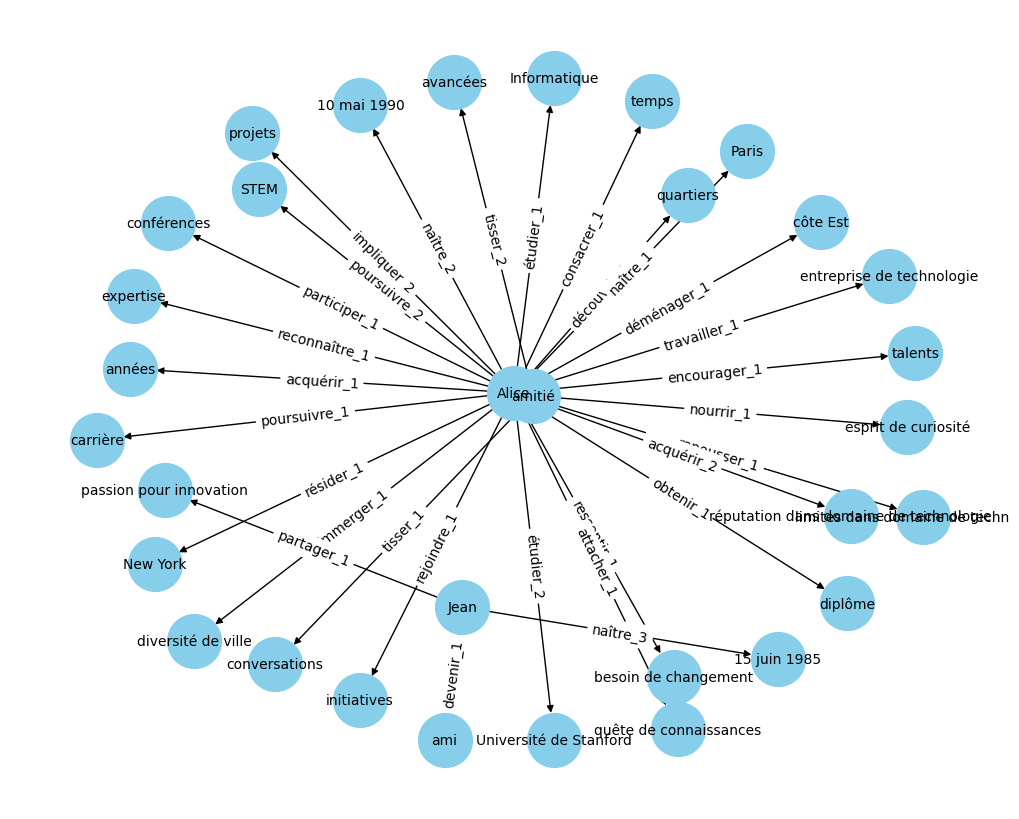

In [58]:
grapheRDF = nx.DiGraph()

for triplet in tripletsRDF:
    grapheRDF.add_edge(triplet[0], triplet[2], relation=triplet[1])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(grapheRDF)
nx.draw(grapheRDF, pos, with_labels=True, node_color="skyblue", node_size=1500, font_size=10)
edge_labels = {(u, v): d["relation"] for u, v, d in grapheRDF.edges(data=True)}
nx.draw_networkx_edge_labels(grapheRDF, pos, edge_labels=edge_labels)
plt.show()

## 8 - Enregistrement du graphe sous format RDF

In [61]:
g = Graph()

ns = Namespace("http://www.semanticweb.org/thivani/ontologies/2024/1/untitled-ontology-4")

for triplet in tripletsRDF:
    sujetURI = URIRef(ns[triplet[0]])
    relationURI = URIRef(ns[triplet[1]])
    objetLiteral = Literal(triplet[2])
    g.add((sujetURI, relationURI, objetLiteral))

g.serialize(destination="graphe.rdf", format="xml")

<Graph identifier=N8c295315669c48c78f483274e99846f0 (<class 'rdflib.graph.Graph'>)>

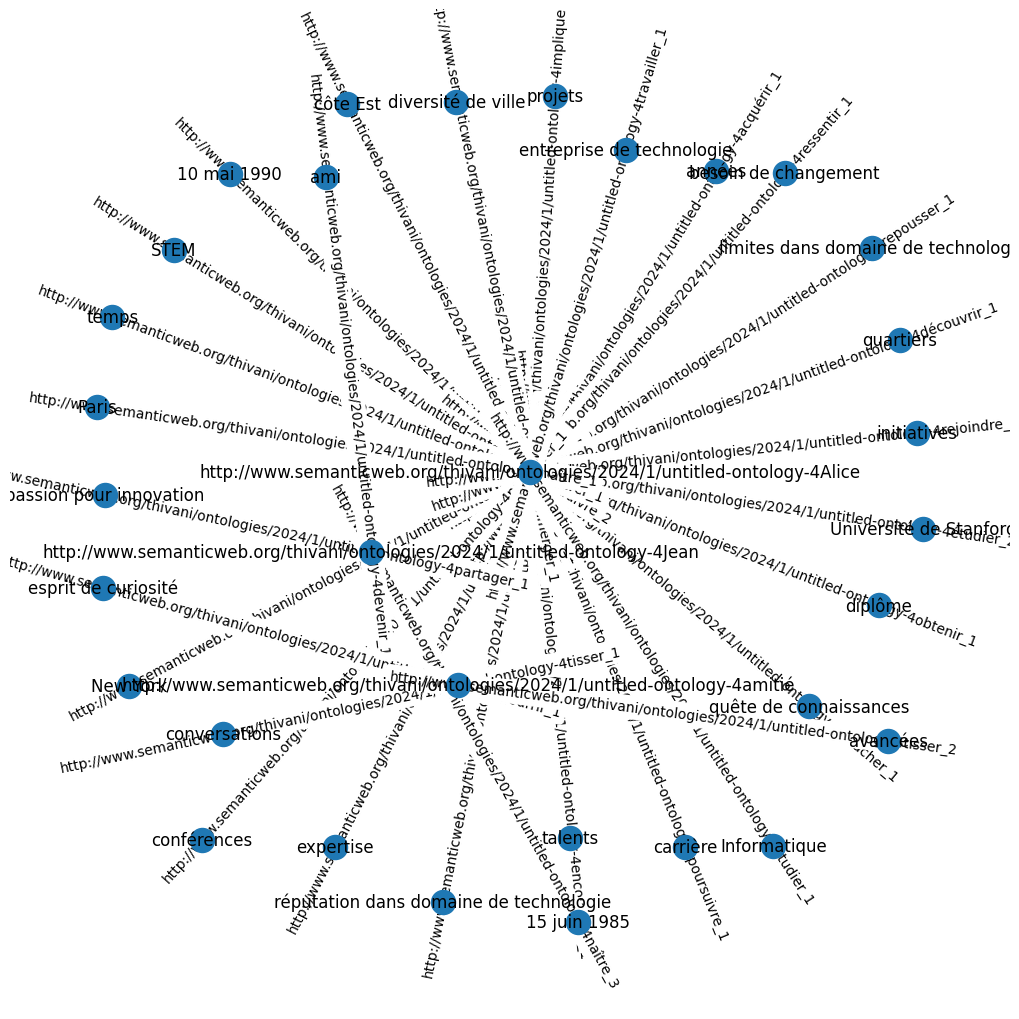

In [60]:
grapheRDF = nx.DiGraph()

for s, p, o in g:
    grapheRDF.add_node(s)
    grapheRDF.add_node(o)
    grapheRDF.add_edge(s, o, label=str(p))

# Visualiser le graphe avec NetworkX
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(grapheRDF)
nx.draw(grapheRDF, pos, with_labels=True, arrows=True)
labels = nx.get_edge_attributes(grapheRDF, 'label')
nx.draw_networkx_edge_labels(grapheRDF, pos, edge_labels=labels)
plt.show()

In [75]:
@staticmethod
def visualize(g: Graph, image_name:str):
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as temp_dot:
        rdf2dot(g, temp_dot, opts = {display})
        temp_dot.flush()

        dg = pydotplus.graph_from_dot_file(temp_dot.name)
        png = dg.create_png()
        dg.write_png(f"{image_name}.png")
        display(Image(png))